In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class ageGenderClassifier(nn.Module):
    """
    ANN multi-task learning class for both VGG16 and RESNET34
    """
    def __init__(self, num_age_classes=9, dropout=0.1):

        super(ageGenderClassifier, self).__init__()

        self.intermediate = nn.Sequential(
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2,inplace=True), 
        )

        self.age_classifier = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(16, num_age_classes)
        )
        self.gender_classifier = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        #print(x.shape)
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        return gender, age

In [39]:
model = models.vgg16(pretrained = True)
# Freeze parameters => no backprop 
for param in model.parameters():
    param.requires_grad = False
model.avgpool = nn.Sequential(nn.Conv2d(512,512, kernel_size=3),
                              nn.MaxPool2d(2),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(2048,512),
                              nn.LeakyReLU(0.2,inplace=True))
model.classifier = ageGenderClassifier()
model.load_state_dict(torch.load("inferences/vgg16.pt"))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
model = models.resnet34(pretrained = True)
# Freeze parameters => no backprop 
for param in model.parameters():
    param.requires_grad = False
model.avgpool = nn.Sequential(nn.Conv2d(512,512, kernel_size=3), 
                              nn.MaxPool2d(2),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(2048,512),
                              nn.LeakyReLU(0.2,inplace=True)
                              ) #nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.fc = ageGenderClassifier()
model.load_state_dict(torch.load("inferences/resnet34.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
def preprocess_image(file):
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    im = cv2.resize(im, (224, 224))
    im = torch.tensor(im).permute(2,0,1)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    im = normalize(im/255.)
    return im[None]

def get_age(age):
    dict_age = {'0-2': 0,
                     '3-9': 1,
                     '10-19': 2,
                     '20-29': 3,
                     '30-39': 4,
                     '40-49': 5,
                     '50-59': 6,
                     '60-69': 7,
                     'more than 70': 8} 
    key_list = list(dict_age.keys())
    val_list = list(dict_age.values())
    position = val_list.index(age)
    return key_list[position]

Predicted gender: Male 0.009093584
Predicted age: 20-29


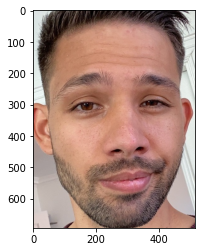

In [42]:
im = preprocess_image('test.jpg').to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = torch.argmax(age, dim=1).detach().numpy()
print('Predicted gender:', np.where(pred_gender[0][0] < 0.5, 'Male','Female'), pred_gender[0][0])
print('Predicted age:', get_age(pred_age)) 